In [1]:
import numpy as np
import gym
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

env = gym.make('MountainCarContinuous-v0')

/home/eek31/Documents/openai/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:
# preprocessing
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.kernel_approximation import RBFSampler

# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to converte a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

def featurize_state(state):
    """
    Returns the featurized representation for a state.
    """
    scaled = scaler.transform([state])
    featurized = featurizer.transform(scaled)
    return featurized[0]

In [3]:
import math

In [4]:
import numpy as np
# import tensorflow_probability as tfp
# tfd = tfp.distributions

In [5]:
from scipy.spatial import distance

import tensorflow as tf
from tensorflow.keras import Input, layers, Model, losses, optimizers



In [6]:
# """
# https://stackoverflow.com/questions/51680818/keras-custom-loss-as-a-function-of-multiple-outputs/51685637
# """

# inputs = Input(shape=(400,))
# prevAction = Input(shape=(1,))
# target = Input(shape=(1,))
# mu = layers.Dense(1)(inputs)
# std = 1.0


# normal_dist = tfp.distributions.Normal(mu, std)
# # normal distribution
# # sampling
# def sampling(args):
#     return normal_dist.sample(1)

# a = layers.Lambda(sampling, output_shape=(1,))([mu, std])
# # clipping
# a = tf.clip_by_value(a, env.action_space.low[0], env.action_space.high[0])

# # consider training in a batch for 1-episode, speed up
# outputs = a
# model = Model(inputs=[inputs, prevAction, target], outputs=[outputs, mu])

# loss = -normal_dist.log_prob(prevAction) * target
# optimizer = "Adam"
# model.add_loss(loss)
# model.compile(optimizer=optimizer)

# model.fit([state, action, action])

# model.predict([state, action, action])

In [7]:
# state = np.reshape(state, (1, 400))

In [8]:
import tensorflow_probability as tfp

In [9]:
class PolicyEstimator():
    def __init__(self, α = 0.01):
        
        inputs = Input(shape=(400,))
        prevAction = Input(shape=(1,))
        target = Input(shape=(1,))
        mu = layers.Dense(1)(inputs)
        std = 1.0

        self.normal_dist = tfp.distributions.Normal(mu, std)
        
        # normal distribution
        # sampling
        def sampling(args):
            return self.normal_dist.sample(1)

        a = layers.Lambda(sampling, output_shape=(1,))([mu, std])

        # clipping
        a = tf.clip_by_value(a, env.action_space.low[0], env.action_space.high[0])
        
        # consider training in a batch for 1-episode, speed up
        self.model = Model(inputs=[inputs, prevAction, target], outputs=[a, mu])

        loss = -self.normal_dist.log_prob(prevAction) * target

        optimizer = "Adam"
        self.model.add_loss(loss)
        self.model.compile(optimizer=optimizer)
                
    def predict(self, state):
        state = np.reshape(state, (1, 400))
        dummy = np.array([0])

        action, _ = self.model.predict([state, dummy, dummy])

        return action[0, 0]
    
    def predictGreedy(self, state):
        state = np.reshape(state, (1, 400))
        dummy = np.array([0])

        _, mu = self.model.predict([state, dummy, dummy])

        return mu[0]
    
    def update(self, state, target, action):
        state = np.reshape(state, (1, 400))
        target = np.array([target])
        action = np.array([action])
        
        self.model.fit([state, action, target], verbose=0)


In [10]:
# """
# need to set sigma to 0 over time
# TODO: maybe build another similar model but with 0 std?
# load the same weights trained on this neural network
# """
# class PolicyEstimator():
#     def __init__(self, α = 0.01):
        
        
#         inputs = Input(shape=(400,))
#         prevAction = Input(shape=(1,))
#         target = Input(shape=(1,))
#         mu = layers.Dense(1)(inputs)
#         std = 1.0

#         self.normal_dist = tfp.distributions.Normal(mu, std)
        
#         # normal distribution
#         # sampling
#         def sampling(args):
#             return self.normal_dist.sample(1)
# #             mu, std = args
# #             epsilon = tf.keras.backend.random_normal(shape=(1, ))
# #             return mu + tf.keras.backend.exp(0.5 * std) * epsilon

#         a = layers.Lambda(sampling, output_shape=(1,))([mu, std])

#         # clipping
#         a = tf.clip_by_value(a, env.action_space.low[0], env.action_space.high[0])
        
#         # consider training in a batch for 1-episode, speed up
#         outputs = a
#         self.model = Model(inputs=[inputs, prevAction, target], outputs=outputs)

# #         # custom loss = log_prob * target
# #         def log_prob_loss(y, target):
# #             # TODO: how to get action is from previous cycle
# #             loss = -self.normal_dist.log_prob(prevAction) * target
# # #             loss = -0.5 * target * tf.keras.backend.square(prevAction - mu)
# #             return loss

#         loss = -self.normal_dist.log_prob(prevAction) * target

#         optimizer = "Adam"
#         self.model.add_loss(loss)
#         self.model.compile(optimizer=optimizer)
# #         self.model.compile(loss=log_prob_loss,
# #              optimizer=optimizer,
# #              experimental_run_tf_function=False)
                
#     def predict(self, state):
#         state = np.reshape(state, (1, 400))
#         dummy = np.array([0])

#         action = self.model.predict([state, dummy, dummy])

#         return action[0, 0]
    
#     def update(self, state, target, action):
#         state = np.reshape(state, (1, 400))
#         target = np.array([target])
#         # TODO: how to pass action
#         action = np.array([action])
        
# #         self.model.fit([state, action], target, verbose=0)
#         self.model.fit([state, action, target], verbose=0)
    
#         # feed both labels as input

In [11]:
# class PolicyEstimator():
#     def __init__(self, α = 0.01):
#         self.θ = np.zeros(400, )
#         self.σ = 1
#         self.α = α
        
#         self.losses = []

#         self.v_dθ = np.zeros(400,)
#         self.β = 0.9
#         self.ε = 1e-10        
        
#     def mu_state(self, state):
#         mu = self.θ @ state
        
#         return mu
        
#     def predict(self, state):
#         mu = self.mu_state(state)
        
#         action = np.random.normal(mu, self.σ, size=(1,))
#         action = np.clip(action, env.action_space.low[0], env.action_space.high[0])
        
#         return action
    
#     def update(self, state, target, action):
        
#         mu = self.mu_state(state)

#         # track losses
#         loss = (-0.5*(((action - mu)/self.σ)**2) - np.log(np.sqrt(2*math.pi))) * target
#         self.losses.append(loss)
        
#         # update θ
#         dloss = -((action - mu)/(self.σ**2)) * state * target
#         # minimize RMSPROP
#         self.v_dθ = self.β * self.v_dθ + (1 - self.β) * (dloss**2) 
#         self.θ -= self.α * dloss/(np.sqrt(self.v_dθ) + self.ε)
        

In [12]:
from scipy.spatial import distance

In [13]:
class ValueEstimator():
    def __init__(self, α = 0.1):
        
        inputs = Input(shape=(400,))
        outputs = layers.Dense(1)(inputs)
        self.model = Model(inputs=inputs, outputs=outputs)
        
        self.model.compile(loss=losses.MeanSquaredError(),
                     optimizer=optimizers.Adam())

        
    def predict(self, state):
        state = np.reshape(state, (1, 400))
        value = self.model.predict(state)

        return value[0, 0]
    
    def update(self, state, target):
        state = np.reshape(state, (1, 400))
        target = np.array([target])
        self.model.fit(state, target, verbose=0)


In [14]:
from tqdm import tqdm_notebook
import time

In [15]:
policy_estimator = PolicyEstimator(α=0.001)
value_estimator = ValueEstimator(α=0.1)

In [16]:
env.close()

In [17]:
"""
TRAIN
"""

num_episodes = 5
num_steps = 1000
discount_factor=0.95

for i in range(num_episodes):
#     policy_estimator.reset()
#     value_estimator.reset()
    
    # set v_dw and v_dθ to 0
    state = env.reset()
    state = featurize_state(state)

    for t in tqdm_notebook(range(num_steps)):
        if i % 10 == 0:
            env.render()
        # take action
        action = policy_estimator.predict(state)

        # execute action
        next_state, reward, done, _ = env.step(action)
        next_state = featurize_state(next_state)

        # calculate TD target
        value_now = value_estimator.predict(state)
        value_next = value_estimator.predict(next_state)
        td_target = reward + discount_factor * value_next
        td_error = td_target - value_now

        # update the value estimator
        value_estimator.update(state, td_target)
        # update the policy estimator
        policy_estimator.update(state, td_error, action)

#         print(state, action, value_now, value_next, td_error)

        if done & (t <= 900):
#             env.render()
#             time.sleep(1)
#             env.close()
            
            break

        state = next_state
    
    env.close()

In [26]:
"""
TEST
"""

num_steps = 1000

state = env.reset()
state = featurize_state(state)

policy_estimator.σ = 0
for t in tqdm_notebook(range(num_steps)):
    env.render()
    
    # take action
#     action = policy_estimator.predict(state)
    action = policy_estimator.predictGreedy(state)

    # execute action
    next_state, reward, done, _ = env.step(action)
    next_state = featurize_state(next_state)


    if done & (t < 900):
        break

    state = next_state
#     time.sleep(0.01)

env.close()

In [19]:
# raise Exception("")

# Visualize Policy

In [20]:
from mpl_toolkits.mplot3d import Axes3D 

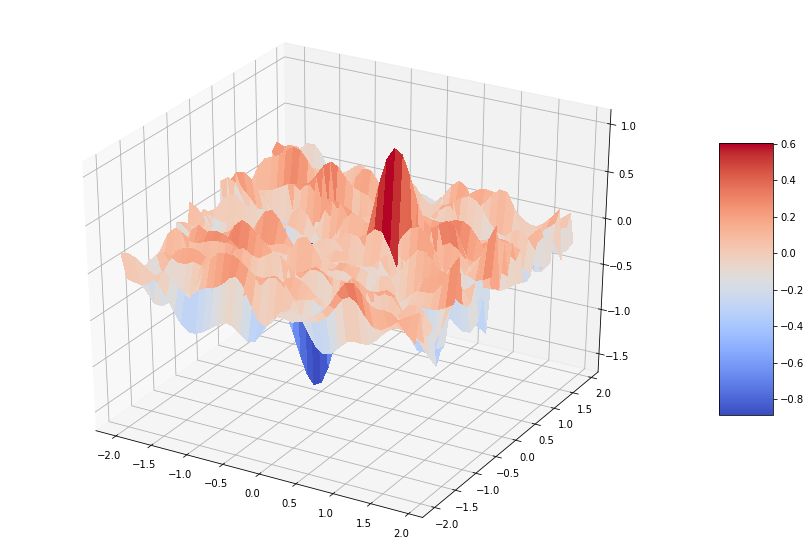

In [21]:
"""
Illustrate Value Network
proxy to objective function
"""

from matplotlib import cm

fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection='3d')
# Make data.
X = np.arange(-2, 2, 0.1)
Y = np.arange(-2, 2, 0.1)
X, Y = np.meshgrid(X, Y)

Z = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = value_estimator.predict(featurize_state([X[i,j], Y[i,j]]))


# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


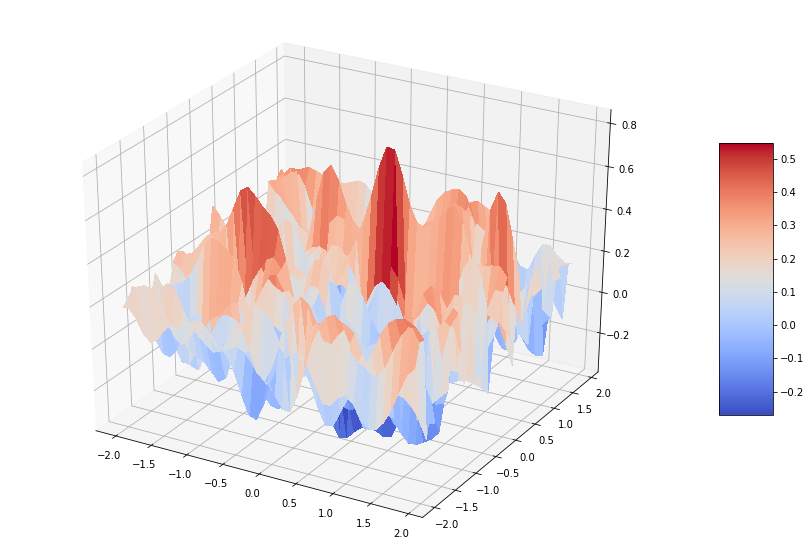

In [22]:
"""
Illustrate Policy Network
proxy to objective function
looks messy because of the non-zero std sigma. Need to rebuild neural network transfer the weights 
but set sigma to 0
"""

from matplotlib import cm

fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection='3d')
# Make data.
X = np.arange(-2, 2, 0.1)
Y = np.arange(-2, 2, 0.1)
X, Y = np.meshgrid(X, Y)

Z = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
#         Z[i, j] = policy_estimator.predict(featurize_state([X[i,j], Y[i,j]]))
        Z[i, j] = policy_estimator.predictGreedy(featurize_state([X[i,j], Y[i,j]]))


# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()
